In [1]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("bbri.csv")
df["Date"] = pd.to_datetime(df["Date"])
ts = df["Close"]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_prediction_df(
    df_to_plot,
    original_data_len,
    tail_percentage=100
    ):
    
    if not 1 <= tail_percentage <= 100:
        raise ValueError("tail_percentage harus di antara 1 dan 100.")
        
    num_rows_to_show = int(len(df_to_plot) * (tail_percentage / 100))
    
    df_display = df_to_plot.tail(num_rows_to_show)
    
    target_column = df_display.columns[0]
    
    split_date = df_to_plot.index[original_data_len - 1]

    df_history_plot = df_display[df_display.index <= split_date]
    df_future_plot = df_display[df_display.index > split_date]
    
    last_history_point = df_history_plot.tail(1)
    df_future_plot_connected = pd.concat([last_history_point, df_future_plot])

    plt.figure(figsize=(15, 7))
    
    # Plot data historis dengan warna biru
    plt.plot(df_history_plot.index, df_history_plot[target_column], color='blue', label='Data Historis')
    
    # Plot data prediksi dengan warna merah dan garis solid
    plt.plot(df_future_plot_connected.index, df_future_plot_connected[target_column], color='red', label='Prediksi')
    
    plt.title(f'Visualisasi Data (Menampilkan {tail_percentage}% Terakhir)')
    plt.xlabel('Tanggal')
    plt.ylabel(f'Harga {target_column}')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_future_df(
    df_input,
    target_column,
    model_path,
    scaler_path,
    num_prediction_days=7
    ):
    
    if not isinstance(df_input.index, pd.DatetimeIndex):
        raise TypeError(
            "Indeks DataFrame bukan tipe tanggal. "
            "Jalankan: df.set_index('Date', inplace=True) terlebih dahulu."
        )

    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    time_steps = model.input_shape[1]
    
    input_data = df_input[target_column].values
    
    if len(input_data) < time_steps:
        raise ValueError(f"Data input tidak cukup. Butuh minimal {time_steps} data.")
    
    last_sequence = np.array(input_data[-time_steps:]).reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)
    input_sequence = last_sequence_scaled.reshape(1, time_steps, 1)

    future_predictions_scaled = []

    for _ in range(num_prediction_days):
        next_pred_scaled = model.predict(input_sequence, verbose=0)
        future_predictions_scaled.append(next_pred_scaled[0, 0])
        input_sequence = np.append(input_sequence[:, 1:, :], [[[next_pred_scaled[0, 0]]]], axis=1)

    predictions_unscaled = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
    
    last_date = df_input.index[-1]
    prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_prediction_days)
    
    df_history = df_input[[target_column]].copy()
    df_future = pd.DataFrame({target_column: predictions_unscaled.flatten()}, index=prediction_dates)
    
    df_prediksi = pd.concat([df_history, df_future])
    
    return df_prediksi

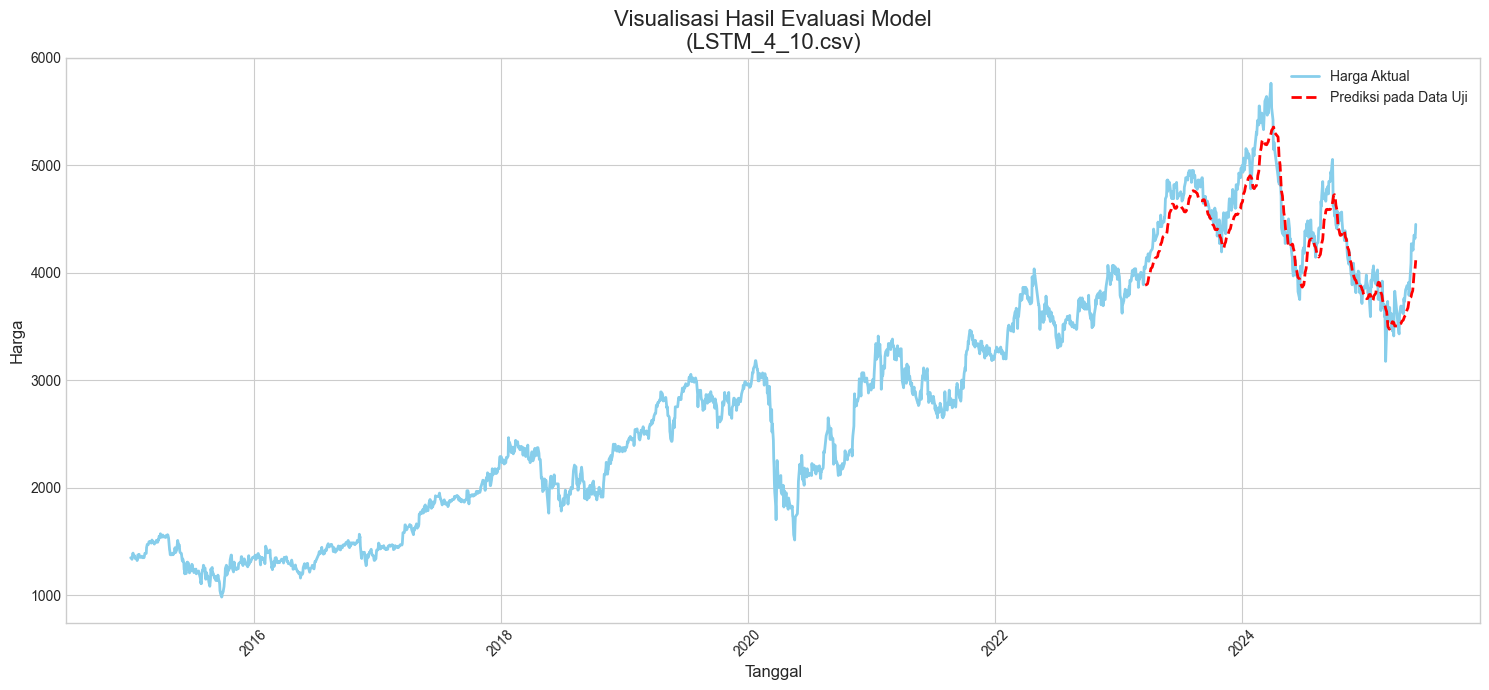

In [5]:
df = pd.read_csv("LSTM_4_10.csv", index_col='Date', parse_dates=True)

plt.style.use('seaborn-v0_8-whitegrid') # Opsional: agar tampilan grafik lebih bagus
plt.figure(figsize=(15, 7))

# Plot harga aktual
plt.plot(df.index, df['Harga_Aktual'], label='Harga Aktual', color='skyblue', linewidth=2)

# Plot prediksi uji, dengan gaya garis putus-putus agar berbeda
plt.plot(df.index, df['Prediksi_Uji'], label='Prediksi pada Data Uji', color='red', linestyle='--', linewidth=2)

# --- 4. Percantik Tampilan Grafik ---
plt.title(f'Visualisasi Hasil Evaluasi Model\n({"LSTM_4_10.csv"})', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout() # Merapikan layout

# --- 5. Tampilkan Grafik ---
plt.show()


In [9]:

path_model = "LSTM_6_150.keras"
path_scaler ="LSTM_6_150_scaler.pkl"

df_hasil_prediksi = predict_future_df(
    df_input=df,
    target_column='Close',
    model_path=path_model,
    scaler_path=path_scaler,
    num_prediction_days=30
)

# print(df_hasil_prediksi.tail(40))

In [1]:
import json
import os

file_path = 'eval_metrics_LSTM_4_50.json'



if not os.path.exists(file_path):
    print(f"Error: File tidak ditemukan di lokasi '{file_path}'")
    print("Pastikan nama file dan path-nya sudah benar.")
else:
    # --- 3. Buka dan baca file JSON ---
    with open(file_path, 'r') as f:
        # json.load() akan mengubah teks JSON menjadi dictionary Python
        data_metrik = json.load(f)

    # --- 4. Tampilkan isinya ---
    print(f"Berhasil membaca file: {file_path}\n")
    
    print("Isi file JSON (sebagai dictionary Python):")
    print(data_metrik)
    print("-" * 30)
    
    # Anda juga bisa mengakses nilainya satu per satu
    print("Nilai per metrik:")
    rmse_value = data_metrik.get("RMSE", "Key tidak ditemukan")
    mape_value = data_metrik.get("MAPE", "Key tidak ditemukan")
    
    print(f"  - Nilai RMSE: {rmse_value}")
    print(f"  - Nilai MAPE: {mape_value}")

Berhasil membaca file: eval_metrics_LSTM_4_50.json

Isi file JSON (sebagai dictionary Python):
{'RMSE': 151.75063025768975, 'MAPE': 2.860844666777631}
------------------------------
Nilai per metrik:
  - Nilai RMSE: 151.75063025768975
  - Nilai MAPE: 2.860844666777631


In [ ]:
model = load_model(path_model)
scaler = joblib.load(path_scaler)
    
time_steps = model.input_shape[1]
print(time_steps)
last_sequence_scaled = scaler.transform(last_sequence)

60


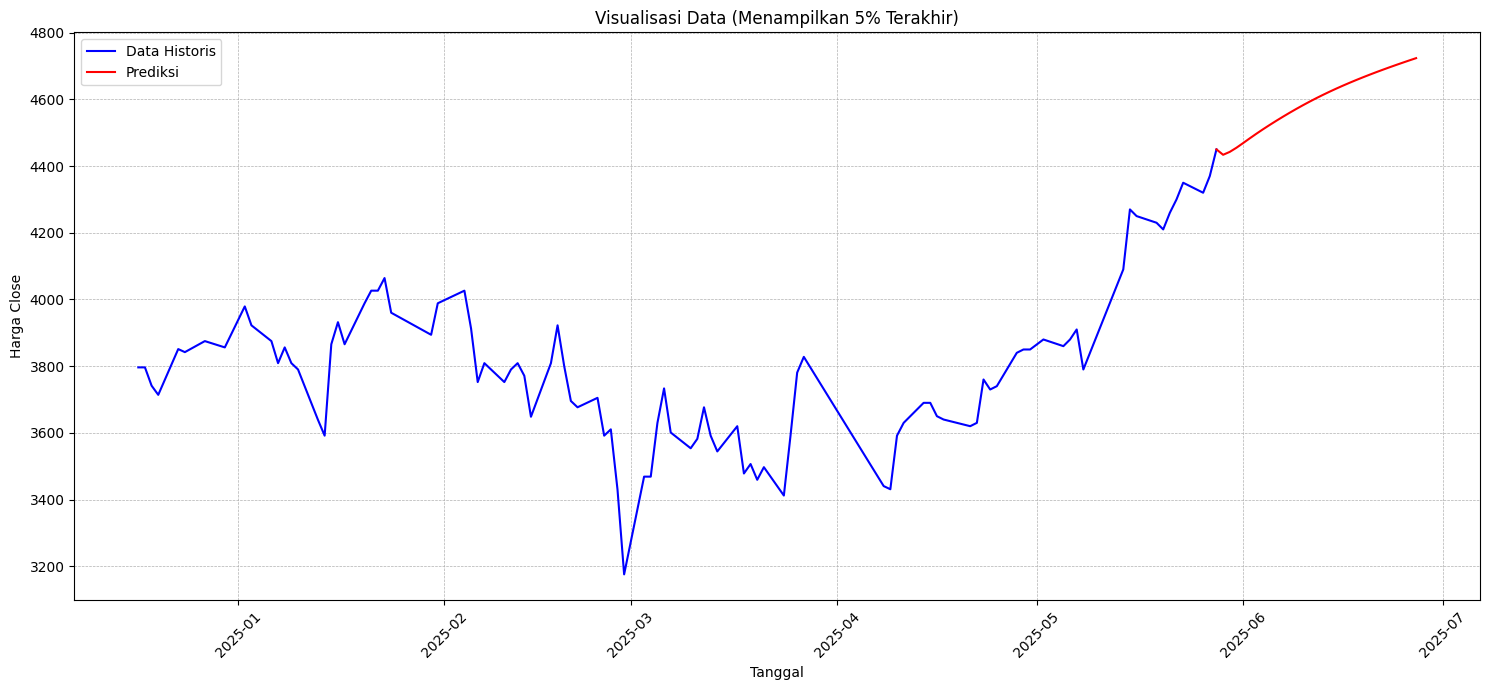

In [10]:
panjang_data_asli = len(df)


plot_prediction_df(
    df_to_plot=df_hasil_prediksi,
    original_data_len=panjang_data_asli,
    tail_percentage=5
)